In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

### Let's investigate the Measurement table

In [9]:
# Create connection to engine and pass it to the sqlalchemy.Table() function along with Metadata
conn = engine.connect()
meta = sqlalchemy.MetaData()
table_measure = sqlalchemy.Table('measurement', meta, autoload=True, autoload_with=engine)
measure_cols = table_measure.c
for c in measure_cols:
    print(c.name, ': ', c.type)

id :  INTEGER
station :  TEXT
date :  TEXT
prcp :  FLOAT
tobs :  FLOAT


#### For the record, we could have accessed the same information by simpy requesting column names from inspector, i.e inspector.get_columns('measurement')

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Last date: 2017-08-23
A year ago: 2016-08-23


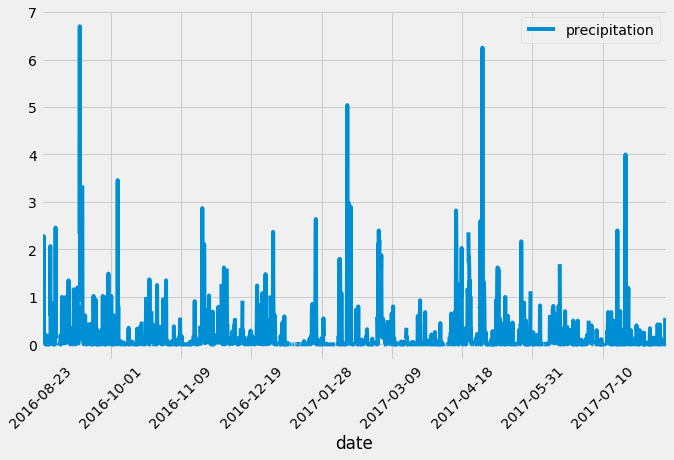

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_date = datetime.strptime(last_date_str, '%Y-%m-%d').date()
twelve_months = relativedelta(months=-12)
relative_date = last_date + twelve_months
print(f'Last date: {last_date}\nA year ago: {relative_date}')

# Perform a query to retrieve the data and precipitation scores

data_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= relative_date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

data = pd.DataFrame(data_query)

# Sort the dataframe by date - The data is already ordered by date but we will still do it.

data = data.sort_values('date')
data = data.set_index('date')
data = data.rename(columns={'prcp': 'precipitation'})
# Use Pandas Plotting with Matplotlib to plot the data

data.plot(figsize=(10,6), rot=45)
plt.show()
data

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
pd.DataFrame(data.precipitation.describe())

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

# We can achhieve the same result by using groupby function that will give us the list of stations and 
# then find the length of the list as follows: Feel free to uncomment to see the result
#session.query(func.count(Measurement.station)).group_by(Measurement.station).all()

number_of_stations = session.query(func.count(distinct(Station.name))).all()[0][0]
number_of_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
import numpy as np
most_active_st = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all() 

most_active_st = pd.DataFrame(np.array(most_active_st), columns = ['station', 'count'])
most_active_st

# The following SQL query does exactly the same thing but written in plain SQL format. I would recommend to crosscheck values

#engine.execute('SELECT station, COUNT(station) as st_count FROM measurement GROUP BY station ORDER BY st_count DESC;').fetchall()

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


It appears that the most active station is USC00519281 since it deliverst the most results.

### Let's calculate the min, max, and avg temperatures that the most active station measured

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temp = session.query(func.min(Measurement.tobs).filter(Measurement.station == 'USC00519281')).all()[0][0]
highest_temp = session.query(func.max(Measurement.tobs).filter(Measurement.station == 'USC00519281')).all()[0][0]
avg_temp = session.query(func.avg(Measurement.tobs).filter(Measurement.station == 'USC00519281')).all()[0][0]

print('Lowest temperature: ', round(lowest_temp, 2),'\nHighest temperature: ', round(highest_temp, 2),\
      '\nAverage Temperature: ', round(avg_temp, 2))

Lowest temperature:  54.0 
Highest temperature:  85.0 
Average Temperature:  71.66


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_temperature_stations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.tobs).desc()).all()

most_temp_st_df = pd.DataFrame(np.array(most_temperature_stations), columns=['station', 'temp_count'])
most_temp_st_df

,station,temp_count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


Again, as it was expected the station that has the most temperature reports is the same station above that had the most precipitation reports.

Let's do find out the frequency of the remperature reported by the given station for the past 12 months

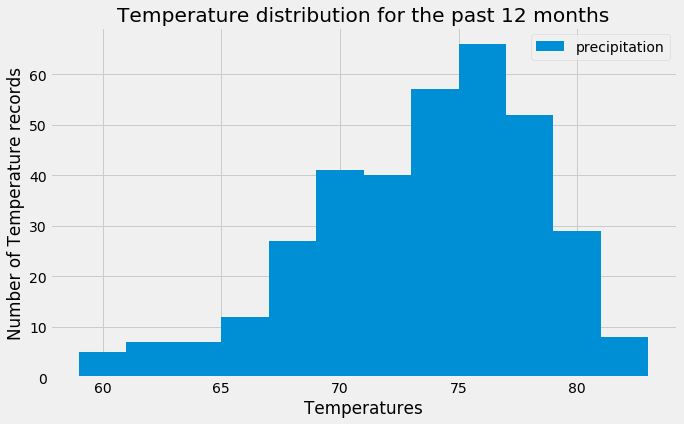

In [17]:
# Create masks. The masks are conditions that we will use in our query filter. 

station = Measurement.station == 'USC00519281'
last_twelve_of_most_active_station = session.query(Measurement.tobs).filter(and_(station, Measurement.date > relative_date)).all()

last_twelve_of_most_active_station = np.array(last_twelve_of_most_active_station)
plt.figure(figsize=(10,6))
plt.xlabel('Temperatures')
plt.ylabel('Number of Temperature records')
plt.title('Temperature distribution for the past 12 months')

plt.hist(last_twelve_of_most_active_station, bins=12, label='precipitation')
plt.legend()
plt.show()


In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


# Choose trip dates

* the trip will last 14 days (2 weeks) starting from relativedate + 2 months til relativedate + 2 months + 14 days

In [19]:
#trip dates
trip_start = relative_date + relativedelta(months=2)
trip_end = trip_start + relativedelta(weeks=2)

print(f"Trip start: {trip_start}\nTrip end: {trip_end}")

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# The dates we have calculated above are stored in
# relative_date(a date that is 12 months before the last data point in the dataset) and last_date which is the last date
# in the dataset

#find temperature stats for the trip dates

temperatures = calc_temps(trip_start, trip_end)[0]
#temperatures = calc_temps('2012-02-28', '2012-03-05')[0]
tmin = temperatures[0]
tavg = temperatures[1]
tmax = temperatures[2]
temperatures

Trip start: 2016-10-23
Trip end: 2016-11-06


(68.0, 75.92708333333333, 81.0)

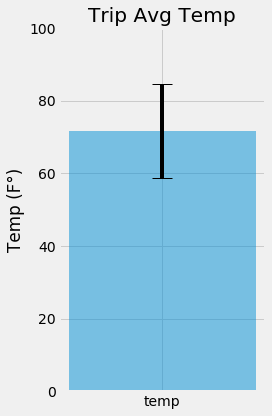

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error = (tmax-tmin) # This is the average temperature error as it is suggested by the assignment
x_pos = 'temp' # just a string to have the x axis.
y_val = avg_temp

fig, ax = plt.subplots()
fig.set_size_inches(4,6)
ax.bar(x_pos, y_val, yerr=error, align= 'center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temp (F\N{DEGREE SIGN})')
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
ax.set_ylim(0,100)

# Save the figure and show
plt.savefig('Avg_temp.png')
plt.tight_layout()
plt.show()


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall_per_station = session.query(Measurement.station, func.sum(Measurement.prcp)).filter(and_(Measurement.date\
                            >=trip_start, Measurement.date <=trip_end)).group_by(Measurement.station).\
                            order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall_per_station_df = pd.DataFrame(total_rainfall_per_station, columns=['Station', 'Sum_rainfall'])
total_rainfall_per_station_df

,Station,Sum_rainfall
0,USC00516128,6.15
1,USC00519281,0.96
2,USC00514830,0.68
3,USC00517948,0.60
4,USC00519523,0.45
5,USC00513117,0.44
6,USC00519397,0.31


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:

# Below code calculates each date of the trip and adds it to the dates list. Because the predefined
# daily_normals function accepts the dates in this format

delta = trip_end - trip_start
dates = []
for i in range(delta.days + 1):
    dates.append((trip_start + relativedelta(days=i)))
dates

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in dates:
    normals.append(daily_normals(date.strftime("%m-%d"))[0])
    
# Just to check if normals are satisfactory
normals

[(66.0, 75.74468085106383, 84.0),
 (69.0, 74.98039215686275, 81.0),
 (68.0, 75.0, 81.0),
 (68.0, 75.17307692307692, 81.0),
 (64.0, 75.12, 81.0),
 (68.0, 74.75471698113208, 82.0),
 (68.0, 74.88679245283019, 81.0),
 (64.0, 74.66, 81.0),
 (67.0, 74.83673469387755, 80.0),
 (65.0, 74.86274509803921, 83.0),
 (64.0, 74.0625, 81.0),
 (66.0, 74.95918367346938, 82.0),
 (65.0, 74.0754716981132, 82.0),
 (64.0, 73.5576923076923, 78.0),
 (66.0, 74.31111111111112, 81.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['min_temp', 'avg_temp', 'max_temp'], index=dates)
normals_df

,min_temp,avg_temp,max_temp
2016-10-23,66.0,75.744681,84.0
2016-10-24,69.0,74.980392,81.0
2016-10-25,68.0,75.000000,81.0
2016-10-26,68.0,75.173077,81.0
2016-10-27,64.0,75.120000,81.0
2016-10-28,68.0,74.754717,82.0
2016-10-29,68.0,74.886792,81.0
2016-10-30,64.0,74.660000,81.0
2016-10-31,67.0,74.836735,80.0
2016-11-01,65.0,74.862745,83.0


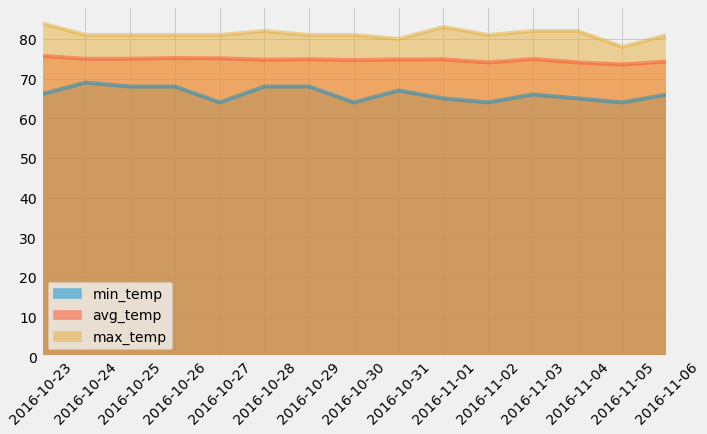

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, figsize=(10,6), xticks=dates, rot=45)
plt.show()